In [1]:
import re, nltk
import sqlalchemy as sql
import pandas as pd
from nltk.corpus import stopwords
from yellowbrick.text import FreqDistVisualizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Set important globals here

In [2]:
# Set limit for reviews
MAX_LIMIT = 100000
# Create database connection
def call_procedure(function_name, params):
    
    connection = sql.create_engine('mysql://root:@localhost/hotel-reviews?charset=utf8').raw_connection()
    try:
        cursor = connection.cursor()
        cursor.callproc(function_name, params)
        results = list(cursor.fetchall())
        cursor.close()
        connection.commit()
        return results
    finally:
        connection.close()
        
def proces_text(the_text):
     # Remove all the special characters (pro_fea = processed feature)
    pro_fea = re.sub(r'\W', ' ', the_text)
    # remove all single characters
    pro_fea = re.sub(r'\s+[a-zA-Z]\s+', ' ', pro_fea)
    # Remove single characters from the start
    pro_fea = re.sub(r'\^[a-zA-Z]\s+', ' ', pro_fea) 
    # Substituting multiple spaces with single space
    pro_fea = re.sub(r'\s+', ' ', pro_fea, flags=re.I)
    # Removing prefixed 'b'
    pro_fea = re.sub(r'^b\s+', '', pro_fea)
    # Converting to Lowercase
    pro_fea = pro_fea.lower()
    return pro_fea

## Get positive and negative reviews

In [3]:
pos = pd.DataFrame(call_procedure('getReviews', [MAX_LIMIT, 1]), columns=['id', 'content', 'positive'])
neg = pd.DataFrame(call_procedure('getReviews', [MAX_LIMIT, 0]), columns=['id', 'content', 'positive'])

print('length pos:', len(pos), 'length neg:', len(neg))

length pos: 100000 length neg: 100000


In [4]:
pos_text = []
pos_labels = []
for df_index, df_value in pos.iterrows():
    pos_text.append(proces_text(df_value['content']))    
    pos_labels.append('pos')
    
neg_text = []
neg_labels = []
for df_index, df_value in neg.iterrows():
    neg_text.append(proces_text(df_value['content']))    
    neg_labels.append('neg')
    
# all lengths should be same as MAX_LIMIT
print('len pos_text:', len(pos_text), 'len pos_labels:', len(pos_labels), 'len neg_text:', len(neg_text), 'len neg_labels:', len(neg_labels))

len pos_text: 100000 len pos_labels: 100000 len neg_text: 100000 len neg_labels: 100000


## Create training and test text/labels

In [5]:
# make the training set 80% of max limit
training_limit = int(MAX_LIMIT * .8)

# Training text and labels are 160% of MAX LIMIT (this is because of merging positive and negative) (and 80% of total)
training_text = pos_text[:training_limit] + neg_text[:training_limit]
training_labels = pos_labels[:training_limit] + neg_labels[:training_limit]

# Test text and labels are 40% of MAX LIMIT (and 20% of total)
test_text = pos_text[training_limit:] + neg_text[training_limit:]
test_labels = pos_labels[training_limit:] + neg_labels[training_limit:]

print('len training_text:', len(training_text), 'len training_labels:', len(training_labels), 'len test_text:', len(test_text), 'len test_labels:', len(test_labels))

len training_text: 160000 len training_labels: 160000 len test_text: 40000 len test_labels: 40000


## Other stuff

In [6]:
vectorizer = CountVectorizer(analyzer='word', lowercase=False, max_features=200, stop_words=stopwords.words('english'))
features = vectorizer.fit_transform(training_text + test_text)
features_nd = features.toarray()

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    features_nd[0:len(training_text)], 
    training_labels,
    train_size=0.80, 
    random_state=1234
)

In [8]:
log_model = LogisticRegression(solver='lbfgs')
log_model = log_model.fit(X=x_train, y=y_train)
y_pred = log_model.predict(x_test)

In [9]:
print(nltk.ConfusionMatrix(list(y_test), list(y_pred)))

    |     n     p |
    |     e     o |
    |     g     s |
----+-------------+
neg |<14705> 1261 |
pos |  2088<13946>|
----+-------------+
(row = reference; col = test)



In [10]:
print(accuracy_score(y_test, y_pred))

0.89534375


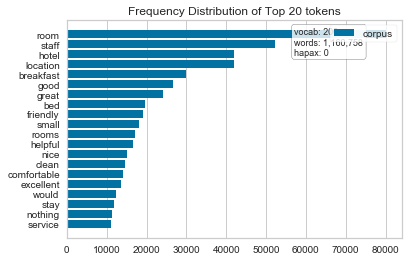

In [11]:
ftr_names = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=ftr_names, n=20)
visualizer.fit(features)
visualizer.show()